In [2]:
import sys
import numpy as np

import matplotlib.pyplot as plt

In [3]:
def obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold):

    # False alarm and miss rates for ASV
    Pfa_asv = sum(non_asv >= asv_threshold) / non_asv.size
    Pmiss_asv = sum(tar_asv < asv_threshold) / tar_asv.size

    # Rate of rejecting spoofs in ASV
    if spoof_asv.size == 0:
        Pmiss_spoof_asv = None
    else:
        Pmiss_spoof_asv = np.sum(spoof_asv < asv_threshold) / spoof_asv.size

    return Pfa_asv, Pmiss_asv, Pmiss_spoof_asv

In [4]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds

In [5]:
def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

In [6]:
def compute_tDCF(bonafide_score_cm, spoof_score_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, print_cost):
    """
    Compute Tandem Detection Cost Function (t-DCF) [1] for a fixed ASV system.
    In brief, t-DCF returns a detection cost of a cascaded system of this form,

      Speech waveform -> [CM] -> [ASV] -> decision

    where CM stands for countermeasure and ASV for automatic speaker
    verification. The CM is therefore used as a 'gate' to decided whether or
    not the input speech sample should be passed onwards to the ASV system.
    Generally, both CM and ASV can do detection errors. Not all those errors
    are necessarily equally cost, and not all types of users are necessarily
    equally likely. The tandem t-DCF gives a principled with to compare
    different spoofing countermeasures under a detection cost function
    framework that takes that information into account.

    INPUTS:

      bonafide_score_cm   A vector of POSITIVE CLASS (bona fide or human)
                          detection scores obtained by executing a spoofing
                          countermeasure (CM) on some positive evaluation trials.
                          trial represents a bona fide case.
      spoof_score_cm      A vector of NEGATIVE CLASS (spoofing attack)
                          detection scores obtained by executing a spoofing
                          CM on some negative evaluation trials.
      Pfa_asv             False alarm (false acceptance) rate of the ASV
                          system that is evaluated in tandem with the CM.
                          Assumed to be in fractions, not percentages.
      Pmiss_asv           Miss (false rejection) rate of the ASV system that
                          is evaluated in tandem with the spoofing CM.
                          Assumed to be in fractions, not percentages.
      Pmiss_spoof_asv     Miss rate of spoof samples of the ASV system that
                          is evaluated in tandem with the spoofing CM. That
                          is, the fraction of spoof samples that were
                          rejected by the ASV system.
      cost_model          A struct that contains the parameters of t-DCF,
                          with the following fields.

                          Ptar        Prior probability of target speaker.
                          Pnon        Prior probability of nontarget speaker (zero-effort impostor)
                          Psoof       Prior probability of spoofing attack.
                          Cmiss_asv   Cost of ASV falsely rejecting target.
                          Cfa_asv     Cost of ASV falsely accepting nontarget.
                          Cmiss_cm    Cost of CM falsely rejecting target.
                          Cfa_cm      Cost of CM falsely accepting spoof.

      print_cost          Print a summary of the cost parameters and the
                          implied t-DCF cost function?

    OUTPUTS:

      tDCF_norm           Normalized t-DCF curve across the different CM
                          system operating points; see [2] for more details.
                          Normalized t-DCF > 1 indicates a useless
                          countermeasure (as the tandem system would do
                          better without it). min(tDCF_norm) will be the
                          minimum t-DCF used in ASVspoof 2019 [2].
      CM_thresholds       Vector of same size as tDCF_norm corresponding to
                          the CM threshold (operating point).

    NOTE:
    o     In relative terms, higher detection scores values are assumed to
          indicate stronger support for the bona fide hypothesis.
    o     You should provide real-valued soft scores, NOT hard decisions. The
          recommendation is that the scores are log-likelihood ratios (LLRs)
          from a bonafide-vs-spoof hypothesis based on some statistical model.
          This, however, is NOT required. The scores can have arbitrary range
          and scaling.
    o     Pfa_asv, Pmiss_asv, Pmiss_spoof_asv are in fractions, not percentages.

    References:

      [1] T. Kinnunen, K.-A. Lee, H. Delgado, N. Evans, M. Todisco,
          M. Sahidullah, J. Yamagishi, D.A. Reynolds: "t-DCF: a Detection
          Cost Function for the Tandem Assessment of Spoofing Countermeasures
          and Automatic Speaker Verification", Proc. Odyssey 2018: the
          Speaker and Language Recognition Workshop, pp. 312--319, Les Sables d'Olonne,
          France, June 2018 (https://www.isca-speech.org/archive/Odyssey_2018/pdfs/68.pdf)

      [2] ASVspoof 2019 challenge evaluation plan
          TODO: <add link>
    """


    # Sanity check of cost parameters
    if cost_model['Cfa_asv'] < 0 or cost_model['Cmiss_asv'] < 0 or \
            cost_model['Cfa_cm'] < 0 or cost_model['Cmiss_cm'] < 0:
        print('WARNING: Usually the cost values should be positive!')

    if cost_model['Ptar'] < 0 or cost_model['Pnon'] < 0 or cost_model['Pspoof'] < 0 or \
            np.abs(cost_model['Ptar'] + cost_model['Pnon'] + cost_model['Pspoof'] - 1) > 1e-10:
        sys.exit('ERROR: Your prior probabilities should be positive and sum up to one.')

    # Unless we evaluate worst-case model, we need to have some spoof tests against asv
    if Pmiss_spoof_asv is None:
        sys.exit('ERROR: you should provide miss rate of spoof tests against your ASV system.')

    # Sanity check of scores
    combined_scores = np.concatenate((bonafide_score_cm, spoof_score_cm))
    if np.isnan(combined_scores).any() or np.isinf(combined_scores).any():
        sys.exit('ERROR: Your scores contain nan or inf.')

    # Sanity check that inputs are scores and not decisions
    n_uniq = np.unique(combined_scores).size
    if n_uniq < 3:
        sys.exit('ERROR: You should provide soft CM scores - not binary decisions')

    # Obtain miss and false alarm rates of CM
    Pmiss_cm, Pfa_cm, CM_thresholds = compute_det_curve(bonafide_score_cm, spoof_score_cm)

    # Constants - see ASVspoof 2019 evaluation plan
    C1 = cost_model['Ptar'] * (cost_model['Cmiss_cm'] - cost_model['Cmiss_asv'] * Pmiss_asv) - \
         cost_model['Pnon'] * cost_model['Cfa_asv'] * Pfa_asv
    C2 = cost_model['Cfa_cm'] * cost_model['Pspoof'] * (1 - Pmiss_spoof_asv)

    # Sanity check of the weights
    if C1 < 0 or C2 < 0:
        sys.exit('You should never see this error but I cannot evalute tDCF with negative weights - please check whether your ASV error rates are correctly computed?')

    # Obtain t-DCF curve for all thresholds
    tDCF = C1 * Pmiss_cm + C2 * Pfa_cm

    # Normalized t-DCF
    tDCF_norm = tDCF / np.minimum(C1, C2)

    # Everything should be fine if reaching here.
    if print_cost:

        print('t-DCF evaluation from [Nbona={}, Nspoof={}] trials\n'.format(bonafide_score_cm.size, spoof_score_cm.size))
        print('t-DCF MODEL')
        print('   Ptar         = {:8.5f} (Prior probability of target user)'.format(cost_model['Ptar']))
        print('   Pnon         = {:8.5f} (Prior probability of nontarget user)'.format(cost_model['Pnon']))
        print('   Pspoof       = {:8.5f} (Prior probability of spoofing attack)'.format(cost_model['Pspoof']))
        print('   Cfa_asv      = {:8.5f} (Cost of ASV falsely accepting a nontarget)'.format(cost_model['Cfa_asv']))
        print('   Cmiss_asv    = {:8.5f} (Cost of ASV falsely rejecting target speaker)'.format(cost_model['Cmiss_asv']))
        print('   Cfa_cm       = {:8.5f} (Cost of CM falsely passing a spoof to ASV system)'.format(cost_model['Cfa_cm']))
        print('   Cmiss_cm     = {:8.5f} (Cost of CM falsely blocking target utterance which never reaches ASV)'.format(cost_model['Cmiss_cm']))
        print('\n   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)')

        if C2 == np.minimum(C1, C2):
            print('   tDCF_norm(s) = {:8.5f} x Pmiss_cm(s) + Pfa_cm(s)\n'.format(C1 / C2))
        else:
            print('   tDCF_norm(s) = Pmiss_cm(s) + {:8.5f} x Pfa_cm(s)\n'.format(C2 / C1))

    return tDCF_norm, CM_thresholds

In [80]:
# Replace CM scores with your own scores or provide score file as the first argument.
cm_score_file_d = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/scores/cm_dev.txt'
# Replace ASV scores with organizers' scores or provide score file as the second argument.
asv_score_file_d = '/Users/asimadnan/Desktop/Mres/tDCF_python_v1/scores/asv_dev.txt'

asv_score_file = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.eval.gi.trl.scores.txt'
#cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-09cm_score.txt'
cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-54svm_cm_score.txt'

In [8]:
# Fix tandem detection cost function (t-DCF) parameters
Pspoof = 0.05
cost_model = {
    'Pspoof': Pspoof,  # Prior probability of a spoofing attack
    'Ptar': (1 - Pspoof) * 0.99,  # Prior probability of target speaker
    'Pnon': (1 - Pspoof) * 0.01,  # Prior probability of nontarget speaker
    'Cmiss_asv': 1,  # Cost of ASV system falsely rejecting target speaker
    'Cfa_asv': 10,  # Cost of ASV system falsely accepting nontarget speaker
    'Cmiss_cm': 1,  # Cost of CM system falsely rejecting target speaker
    'Cfa_cm': 10,  # Cost of CM system falsely accepting spoof
}


In [92]:
def tdfc(asv_score_file,cm_score_file):

    # Load organizers' ASV scores
    asv_data = np.genfromtxt(asv_score_file, dtype=str)
    asv_sources = asv_data[:, 0]
    asv_keys = asv_data[:, 1]
    asv_scores = asv_data[:, 2].astype(np.float)

    # Load CM scores
    cm_data = np.genfromtxt(cm_score_file, dtype=str)
    cm_utt_id = cm_data[:, 0]
    cm_sources = cm_data[:, 1]
    cm_keys = cm_data[:, 2]
    cm_scores = cm_data[:, 3].astype(np.float)

    # Extract target, nontarget, and spoof scores from the ASV scores
    tar_asv = asv_scores[asv_keys == 'target']
    non_asv = asv_scores[asv_keys == 'nontarget']
    spoof_asv = asv_scores[asv_keys == 'spoof']

    # Extract bona fide (real human) and spoof scores from the CM scores
    bona_cm = cm_scores[cm_keys == 'bonafide']
    spoof_cm = cm_scores[cm_keys == 'spoof']

    # EERs of the standalone systems and fix ASV operating point to EER threshold
    eer_asv, asv_threshold = compute_eer(tar_asv, non_asv)
    eer_cm = compute_eer(bona_cm, spoof_cm)[0]

    print('eer asv:',eer_asv)
    print('eer cm:',eer_cm)

    [Pfa_asv, Pmiss_asv, Pmiss_spoof_asv] = obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold)

    tDCF_curve, CM_thresholds = compute_tDCF(bona_cm, spoof_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, True)

    min_tDCF_index = np.argmin(tDCF_curve)
    min_tDCF = tDCF_curve[min_tDCF_index]

    print('ASV SYSTEM')
    print('   EER            = {:8.5f} % (Equal error rate (target vs. nontarget discrimination)'.format(eer_asv * 100))
    print('   Pfa            = {:8.5f} % (False acceptance rate of nontargets)'.format(Pfa_asv * 100))
    print('   Pmiss          = {:8.5f} % (False rejection rate of targets)'.format(Pmiss_asv * 100))
    print('   1-Pmiss,spoof  = {:8.5f} % (Spoof false acceptance rate)'.format((1 - Pmiss_spoof_asv) * 100))

    print('\nCM SYSTEM')
    print('   EER            = {:8.5f} % (Equal error rate for countermeasure)'.format(eer_cm * 100))

    print('\nTANDEM')
    print('   min-tDCF       = {:8.5f}'.format(min_tDCF))

In [93]:
asv_score_file = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.eval.gi.trl.scores.txt'
#cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-09cm_score.txt'
cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-54svm_cm_score.txt'
print('SVM SCORE')
tdfc(asv_score_file,cm_score_file)

SVM SCORE
eer asv: 0.02457783738686887
eer cm: 0.8511601492354752
t-DCF evaluation from [Nbona=1834, Nspoof=16039] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa_asv      = 10.00000 (Cost of ASV falsely accepting a nontarget)
   Cmiss_asv    =  1.00000 (Cost of ASV falsely rejecting target speaker)
   Cfa_cm       = 10.00000 (Cost of CM falsely passing a spoof to ASV system)
   Cmiss_cm     =  1.00000 (Cost of CM falsely blocking target utterance which never reaches ASV)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)
   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)

ASV SYSTEM
   EER            =  2.45778 % (Equal error rate (target vs. nontarget discrimination)
   Pfa            =  2.46047 % (False acceptance rate of nontargets)
   Pmiss          =  2.45810 %

In [94]:
asv_score_file = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.eval.gi.trl.scores.txt'
cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-09cm_score.txt'
#cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-54svm_cm_score.txt'
print('GMM SCORE')
tdfc(asv_score_file,cm_score_file)

GMM SCORE
eer asv: 0.02457783738686887
eer cm: 0.16564595853223907
t-DCF evaluation from [Nbona=1834, Nspoof=16039] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa_asv      = 10.00000 (Cost of ASV falsely accepting a nontarget)
   Cmiss_asv    =  1.00000 (Cost of ASV falsely rejecting target speaker)
   Cfa_cm       = 10.00000 (Cost of CM falsely passing a spoof to ASV system)
   Cmiss_cm     =  1.00000 (Cost of CM falsely blocking target utterance which never reaches ASV)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)
   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)

ASV SYSTEM
   EER            =  2.45778 % (Equal error rate (target vs. nontarget discrimination)
   Pfa            =  2.46047 % (False acceptance rate of nontargets)
   Pmiss          =  2.45810 

# Baseline EER & t-DCF


| Type     	| Feature  	| t-DCF   	| EER %    	|
|----------	|----------	|---------	|----------	|
| Baseline 	| LFCC-GMM 	| 0.0663  	| 2.71     	|
| Baseline 	| CQCC-GMM 	| 0.0123  	| 0.43     	|
| Our      	| MFCC-GMM 	| 0.31006 	| 16.56460 	|
| Our      	| MFCC-SVM 	| 0.99969 	| 85.11601 	|

In [95]:
asv_score_file = '/Users/asimadnan/Desktop/Mres/ASVSPOOF_DATA/LA/ASVspoof2019_LA_asv_scores/ASVspoof2019.LA.asv.eval.gi.trl.scores.txt'
cm_score_file = '/Users/asimadnan/Desktop/Mres/Experiments/Models/25-03-2021_11-09cm_score.txt'

asv_data = np.genfromtxt(asv_score_file, dtype=str)
asv_sources = asv_data[:, 0]
asv_keys = asv_data[:, 1]
asv_scores = asv_data[:, 2].astype(np.float)

# Load CM scores
cm_data = np.genfromtxt(cm_score_file, dtype=str)
cm_utt_id = cm_data[:, 0]
cm_sources = cm_data[:, 1]
cm_keys = cm_data[:, 2]
cm_scores = cm_data[:, 3].astype(np.float)

# Extract target, nontarget, and spoof scores from the ASV scores
tar_asv = asv_scores[asv_keys == 'target']
non_asv = asv_scores[asv_keys == 'nontarget']
spoof_asv = asv_scores[asv_keys == 'spoof']

# Extract bona fide (real human) and spoof scores from the CM scores
bona_cm = cm_scores[cm_keys == 'bonafide']
spoof_cm = cm_scores[cm_keys == 'spoof']

# EERs of the standalone systems and fix ASV operating point to EER threshold
eer_asv, asv_threshold = compute_eer(tar_asv, non_asv)
eer_cm = compute_eer(bona_cm, spoof_cm)[0]

print('eer asv:',eer_asv)
print('eer cm:',eer_cm)

[Pfa_asv, Pmiss_asv, Pmiss_spoof_asv] = obtain_asv_error_rates(tar_asv, non_asv, spoof_asv, asv_threshold)

tDCF_curve, CM_thresholds = compute_tDCF(bona_cm, spoof_cm, Pfa_asv, Pmiss_asv, Pmiss_spoof_asv, cost_model, True)

min_tDCF_index = np.argmin(tDCF_curve)
min_tDCF = tDCF_curve[min_tDCF_index]

print('ASV SYSTEM')
print('   EER            = {:8.5f} % (Equal error rate (target vs. nontarget discrimination)'.format(eer_asv * 100))
print('   Pfa            = {:8.5f} % (False acceptance rate of nontargets)'.format(Pfa_asv * 100))
print('   Pmiss          = {:8.5f} % (False rejection rate of targets)'.format(Pmiss_asv * 100))
print('   1-Pmiss,spoof  = {:8.5f} % (Spoof false acceptance rate)'.format((1 - Pmiss_spoof_asv) * 100))

print('\nCM SYSTEM')
print('   EER            = {:8.5f} % (Equal error rate for countermeasure)'.format(eer_cm * 100))

print('\nTANDEM')
print('   min-tDCF       = {:8.5f}'.format(min_tDCF))

eer asv: 0.02457783738686887
eer cm: 0.16564595853223907
t-DCF evaluation from [Nbona=1834, Nspoof=16039] trials

t-DCF MODEL
   Ptar         =  0.94050 (Prior probability of target user)
   Pnon         =  0.00950 (Prior probability of nontarget user)
   Pspoof       =  0.05000 (Prior probability of spoofing attack)
   Cfa_asv      = 10.00000 (Cost of ASV falsely accepting a nontarget)
   Cmiss_asv    =  1.00000 (Cost of ASV falsely rejecting target speaker)
   Cfa_cm       = 10.00000 (Cost of CM falsely passing a spoof to ASV system)
   Cmiss_cm     =  1.00000 (Cost of CM falsely blocking target utterance which never reaches ASV)

   Implied normalized t-DCF function (depends on t-DCF parameters and ASV errors), s=CM threshold)
   tDCF_norm(s) =  2.40595 x Pmiss_cm(s) + Pfa_cm(s)

ASV SYSTEM
   EER            =  2.45778 % (Equal error rate (target vs. nontarget discrimination)
   Pfa            =  2.46047 % (False acceptance rate of nontargets)
   Pmiss          =  2.45810 % (False r

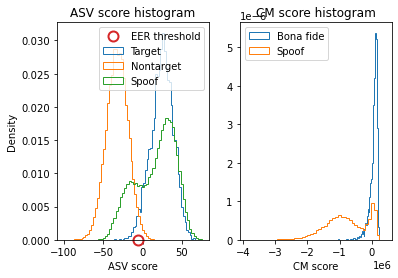

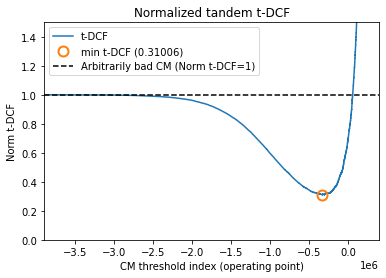

In [96]:
plt.figure()
ax = plt.subplot(121)
plt.hist(tar_asv, histtype='step', density=True, bins=50, label='Target')
plt.hist(non_asv, histtype='step', density=True, bins=50, label='Nontarget')
plt.hist(spoof_asv, histtype='step', density=True, bins=50, label='Spoof')
plt.plot(asv_threshold, 0, 'o', markersize=10, mfc='none', mew=2, clip_on=False, label='EER threshold')
plt.legend()
plt.xlabel('ASV score')
plt.ylabel('Density')
plt.title('ASV score histogram')

ax = plt.subplot(122)
plt.hist(bona_cm, histtype='step', density=True, bins=50, label='Bona fide')
plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='Spoof')
plt.legend()
plt.xlabel('CM score')
#plt.ylabel('Density')
plt.title('CM score histogram')


# Plot t-DCF as function of the CM threshold.
plt.figure()
plt.plot(CM_thresholds, tDCF_curve)
plt.plot(CM_thresholds[min_tDCF_index], min_tDCF, 'o', markersize=10, mfc='none', mew=2)
plt.xlabel('CM threshold index (operating point)')
plt.ylabel('Norm t-DCF');
plt.title('Normalized tandem t-DCF')
plt.plot([np.min(CM_thresholds), np.max(CM_thresholds)], [1, 1], '--', color='black')
plt.legend(('t-DCF', 'min t-DCF ({:.5f})'.format(min_tDCF), 'Arbitrarily bad CM (Norm t-DCF=1)'))
plt.xlim([np.min(CM_thresholds), np.max(CM_thresholds)])
plt.ylim([0, 1.5])

plt.show()
